# Beyond the Pipeline - Charts and Analysis
Author A, Author B.


## Charts generated by this document
* ~US-wide faculty diversity, set against demographic projections~
* Candidate pool trends since 2012 (combining NSF survey of earned doctorates with IPEDS data)
* Charts showing distribution of trends for instituion groups:
    * Ivy+ (Chetty)
    * R1 (Carnegie)
    * National Liberal Arts Colleges (US News)
* Illustration of selected institutions, in context of their peers


References:
* [Data preparation code](github.com/natematias/ipeds-data-analysis)

**TODO**:
* Consider pulling 2014 from the IPEDS data, since reporting some information was optional, so institutions under-reported that year.


In [301]:
library(ggplot2)
library(MASS) # includes CrossTable, should we need it
library(lme4)     # random intercepts
library(lmerTest) # random intercepts significance testing
library(plm)       # fixed effects models
library(stringr)
library(grid)
library(gridExtra) #arrange charts in a grid layout
library(fs)
library(gmodels) # contains CrossTable
library(xtable)
library(readxl)

#color-blind palette
cbPalette <- c("#999999", "#E69F00", "#56B4E9", "#009E73", "#F0E442", "#0072B2", "#D55E00", "#CC79A7")
safe_colorblind_palette <- c("#88CCEE", "#CC6677", "#DDCC77", "#117733", "#332288", "#AA4499", 
                             "#44AA99", "#999933", "#882255", "#661100", "#6699CC", "#888888")


In [319]:
data.path = "/Users/nathan/Box/Projects/"
nces.path = "2021-NCES-Faculty-Data/"
nsed.path = "2021-NSF-Survey-Earned-Doctorates/"

## this generation date includes 2020-2021 
generation.date = "20220109"
nsed.generation.date = "20220213"

year.df   <- read.csv(paste(data.path, nces.path, generation.date, "_year_summary_table.csv", sep=""),na.strings = "")
merged.df <- read.csv(paste(data.path, nces.path, nsed.generation.date, "_nces_unhired_simulation.csv", sep=""), na.strings="")


image.dir <- "../figures/"

projection.end.year = 2060
projection.begin.year = 2013

In [303]:
## generate percentage of tenured / un-tenured black, latino, american indian, alaska native

year.df$tenured_un_tenured_black_latino_american_indian_alaska_native_hawaiian_pacific_multiracial_sum <- 
    year.df$tenured_un_tenured_American_Indian_or_Alaska_Native_total_sum +
    year.df$tenured_un_tenured_Black_or_African_American_total_sum +
    year.df$tenured_un_tenured_Hispanic_or_Latino_total_sum +
    year.df$tenured_un_tenured_Native_Hawaiian_or_Other_Pacific_Islander_total_sum +
    year.df$tenured_un_tenured_Two_or_more_races_total_sum

year.df$tenured_un_tenured_black_latino_american_indian_alaska_native_hawaiian_pacific_multiracial_pct <- 
    year.df$tenured_un_tenured_black_latino_american_indian_alaska_native_hawaiian_pacific_multiracial_sum / 
    year.df$tenured_un_tenured_Grand_total_sum


## un-tenured sum, used in the pipeline calculation
year.df$un_tenured_black_latino_american_indian_alaska_native_hawaiian_pacific_multiracial_sum <- 
    year.df$un_tenured_American_Indian_or_Alaska_Native_total_sum +
    year.df$un_tenured_Black_or_African_American_total_sum +
    year.df$un_tenured_Hispanic_or_Latino_total_sum +
    year.df$un_tenured_Native_Hawaiian_or_Other_Pacific_Islander_total_sum +
    year.df$un_tenured_Two_or_more_races_total_sum

# Plot US-wide tenure-track faculty diversity against demographic projections

Based on the [2017 US census population projections](https://www.census.gov/data/tables/2017/demo/popproj/2017-summary-tables.html), the rate of change in the above demographics is an increase (in proportion) of 0.002 (or 2 tenths of a percentage point) per year through 2060.



### Record Demographic Percentages
Source: [US 2020 census](https://www.census.gov/quickfacts/fact/table/US/PST045219)

* Black or African American: 13.4%
* American Indian and Alaska Native: 1.3%
* Native Hawaiian and Other Pacific Islander: 0.2%
* Hispanic or Latino: 18.5%
* Two or more races: 2.8%
* **Total**: 36.2

In [304]:
urm.prop <- .362
## now let's adjust for the percentage of faculty who are nonresident aliens

urm.prop.adjusted = (urm.prop * (1-mean(year.df$tenured_un_tenured_Nonresident_alien_total_pct)/100))

### Estimate linear model of change
If you are wondering about goodness of fit, observe that the R2 is 0.99. It's definitely a linear trend.

In [305]:
year.df$year.zeroed <- year.df$year-projection.begin.year
summary(linear.m1 <- lm(tenured_un_tenured_black_latino_american_indian_alaska_native_hawaiian_pacific_multiracial_pct ~ year.zeroed, data=year.df))


Call:
lm(formula = tenured_un_tenured_black_latino_american_indian_alaska_native_hawaiian_pacific_multiracial_pct ~ 
    year.zeroed, data = year.df)

Residuals:
       Min         1Q     Median         3Q        Max 
-8.452e-04 -3.495e-04  3.956e-05  4.305e-04  6.628e-04 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept) 1.136e-01  3.659e-04  310.42 7.54e-14 ***
year.zeroed 2.335e-03  8.747e-05   26.69 1.83e-07 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.0005669 on 6 degrees of freedom
Multiple R-squared:  0.9916,	Adjusted R-squared:  0.9903 
F-statistic: 712.5 on 1 and 6 DF,  p-value: 1.826e-07


In [306]:
### estimate faculty diversity through 2060
### the last year that the US government provides
### race/ethnicity demographic projections

years.to.projection.end <- projection.end.year-projection.begin.year
projection.2060.df <- data.frame(
    year = c(projection.begin.year, projection.end.year),
    tenured_un_tenured_black_latino_american_indian_alaska_native_hawaiian_pacific_multiracial_pct = c(
        summary(linear.m1)$coefficients['(Intercept)',][['Estimate']],
        summary(linear.m1)$coefficients['(Intercept)',][['Estimate']] +
        years.to.projection.end * summary(linear.m1)$coefficients['year.zeroed',][['Estimate']]
    )
)

In [307]:
### estimate racial/ethnic diversity through 2060
### based on US census projections

pop.projection.df <- data.frame(
    year = c(projection.begin.year, projection.end.year),
    tenured_un_tenured_black_latino_american_indian_alaska_native_hawaiian_pacific_multiracial_pct = c(
        urm.prop.adjusted,
        urm.prop.adjusted + years.to.projection.end*0.002
    )
)
pop.projection.df

year,tenured_un_tenured_black_latino_american_indian_alaska_native_hawaiian_pacific_multiracial_pct
2013,0.35052
2060,0.44452


In [308]:
labels.df <- data.frame(text=c("Projected Census %", "Projected Faculty %"),
                        x = c(projection.begin.year, projection.begin.year),
                        y = c(0.35, 0.1))

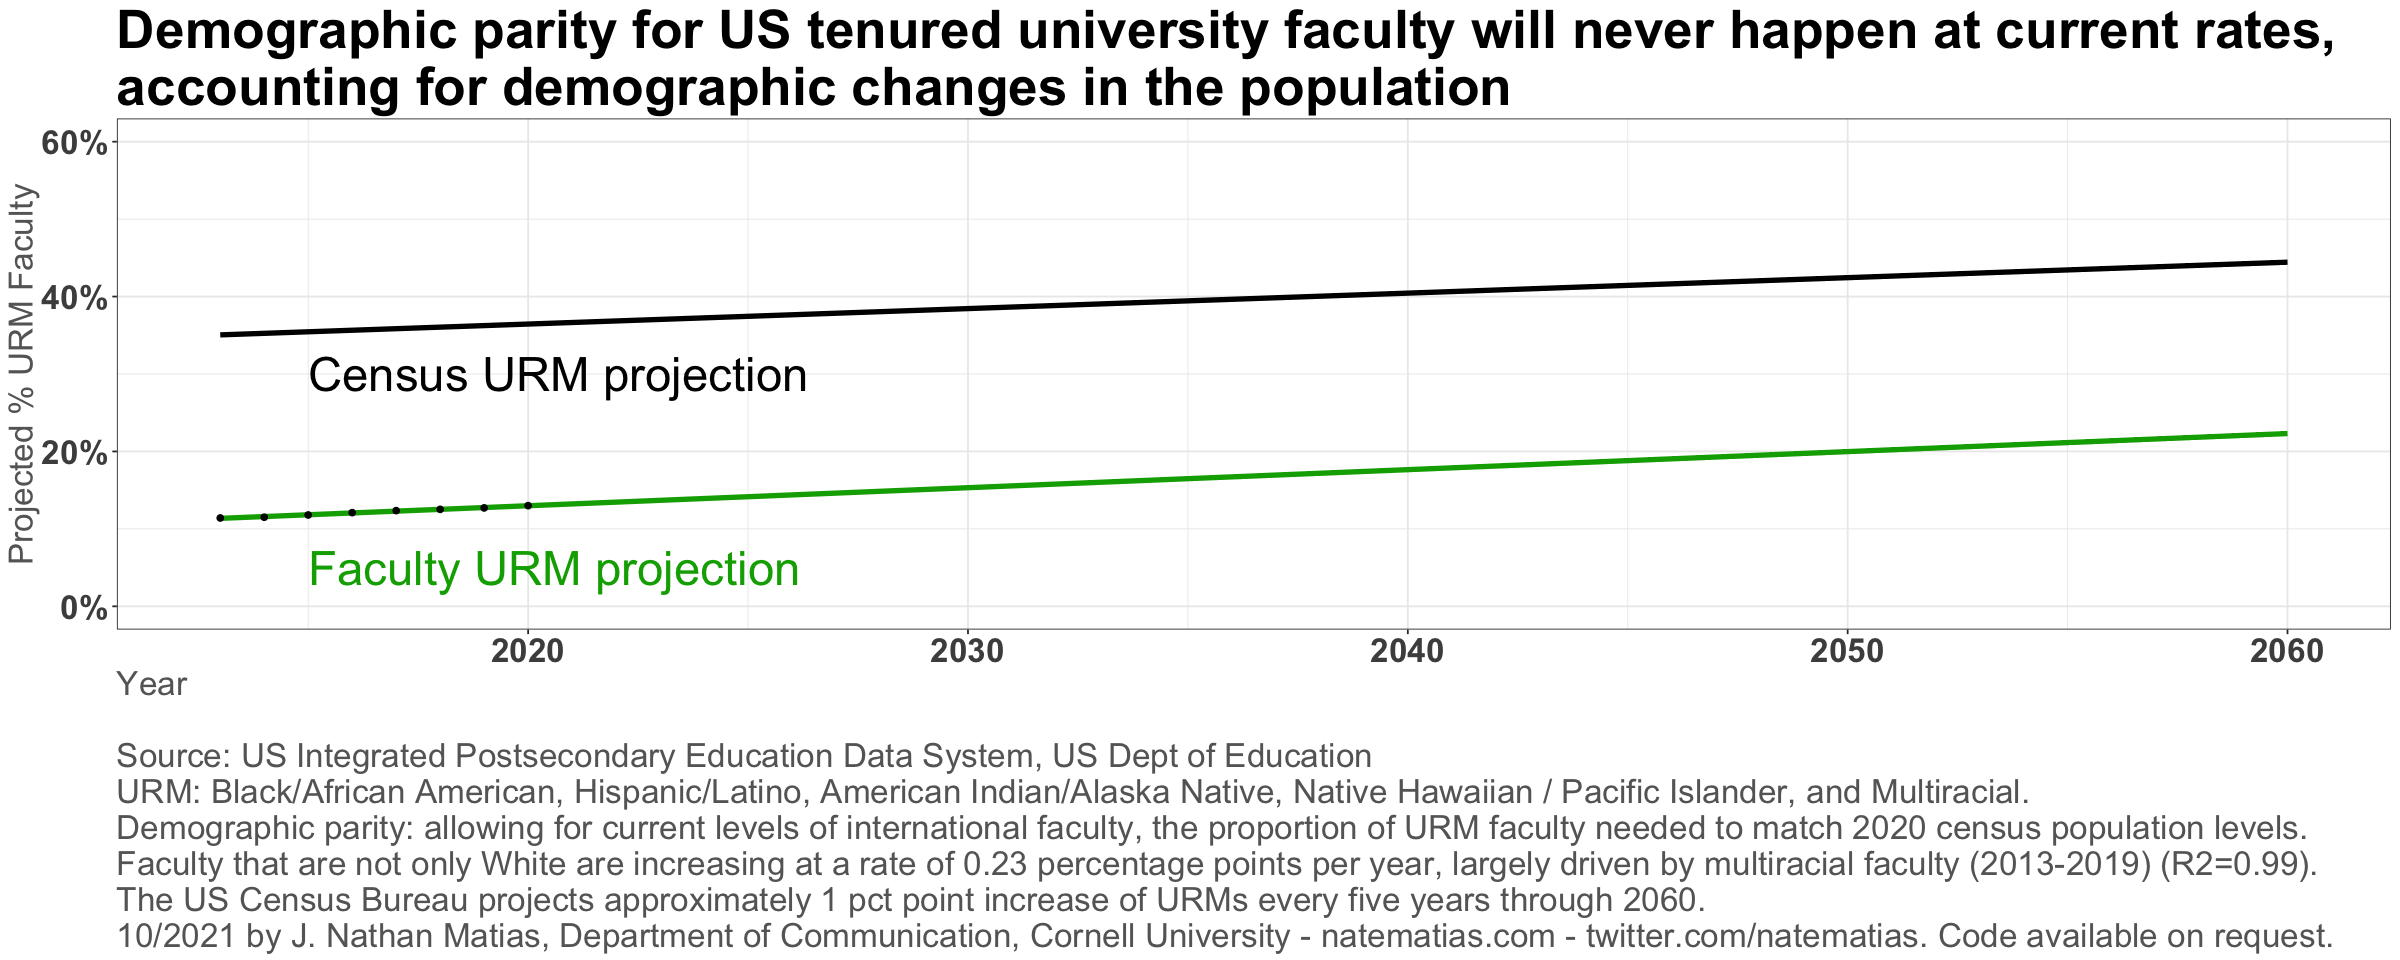

In [309]:
options(repr.plot.width=20, repr.plot.height=8)

ggplot(year.df, aes(year, tenured_un_tenured_black_latino_american_indian_alaska_native_hawaiian_pacific_multiracial_pct)) +
    geom_line(data=projection.2060.df, color="#00aa00", size=1.5) +
    geom_point() +
    geom_line(data=pop.projection.df, color="black", size=1.5) +
    annotate(geom="text", x=2015, y=0.3, label="Census URM projection",size=10, hjust=0) +
    annotate(geom="text", x=2015, y=0.05, label="Faculty URM projection",size=10, hjust=0, color="#00aa00") +
    scale_y_continuous(labels = scales::percent_format(accuracy=1), limits=c(0,0.6)) +
    scale_x_continuous(breaks=seq(2010, 2120, by=10)) +
    theme_bw() +
    theme(text         = element_text(size=20),
          plot.title   = element_text(size=32, face="bold"),
          axis.text.x  = element_text(size=20, face="bold"),
          axis.text.y  = element_text(size=20, face="bold"),
          axis.title.x = element_text(hjust=0, color="#666666"),
          axis.title.y = element_text(color="#666666")) +
    ylab("Projected % URM Faculty") +
    xlab(paste("Year\n\n",
               "Source: US Integrated Postsecondary Education Data System, US Dept of Education\n",
               "URM: Black/African American, Hispanic/Latino, American Indian/Alaska Native, Native Hawaiian / Pacific Islander, and Multiracial.\n",
               "Demographic parity: allowing for current levels of international faculty, the proportion of URM faculty needed to match 2020 census population levels.\n",
               "Faculty that are not only White are increasing at a rate of ", 
               prettyNum(summary(linear.m1)$coefficients['year.zeroed',][['Estimate']]*100, digits=2),
               " percentage points per year, largely driven by multiracial faculty (2013-2019) (R2=0.99).\n",
               "The US Census Bureau projects approximately 1 pct point increase of URMs every five years through 2060.\n",
               "10/2021 by J. Nathan Matias, Department of Communication, Cornell University - natematias.com - twitter.com/natematias. Code available on request.",
               sep="")) +
    ggtitle(paste("Demographic parity for US tenured university faculty will never happen at current rates,\n",
                  "accounting for demographic changes in the population", 
                  sep=""))


# Plot NSF Survey of Earned Doctorates against Tenure Track Faculty

In this chart, we plot the cumulative number of earned doctorates against tenure track faculty.

Data from the [NSF Survey of Earned Doctorates](https://ncses.nsf.gov/pubs/nsf22300/data-tables
), "Doctoral Recipients from U.S. Universities: 2020" file `nsf22300-tab019.xlsx` published on Oct 5, 2021.

To generate a conservative estimate of how many under-represented minorities have earned PhDs, we include only US citizen or permanent residents in the following groups:
* Hispanic or Latino
* American Indian or Alaska Native
* Black or African American
* More than one Race

Note: the Survey of Earned Doctorates does not record records for Native Hawaiian or Other Pacific Islander participants.

Data generation code `Merge Earned Doctorates Data.ipynby`

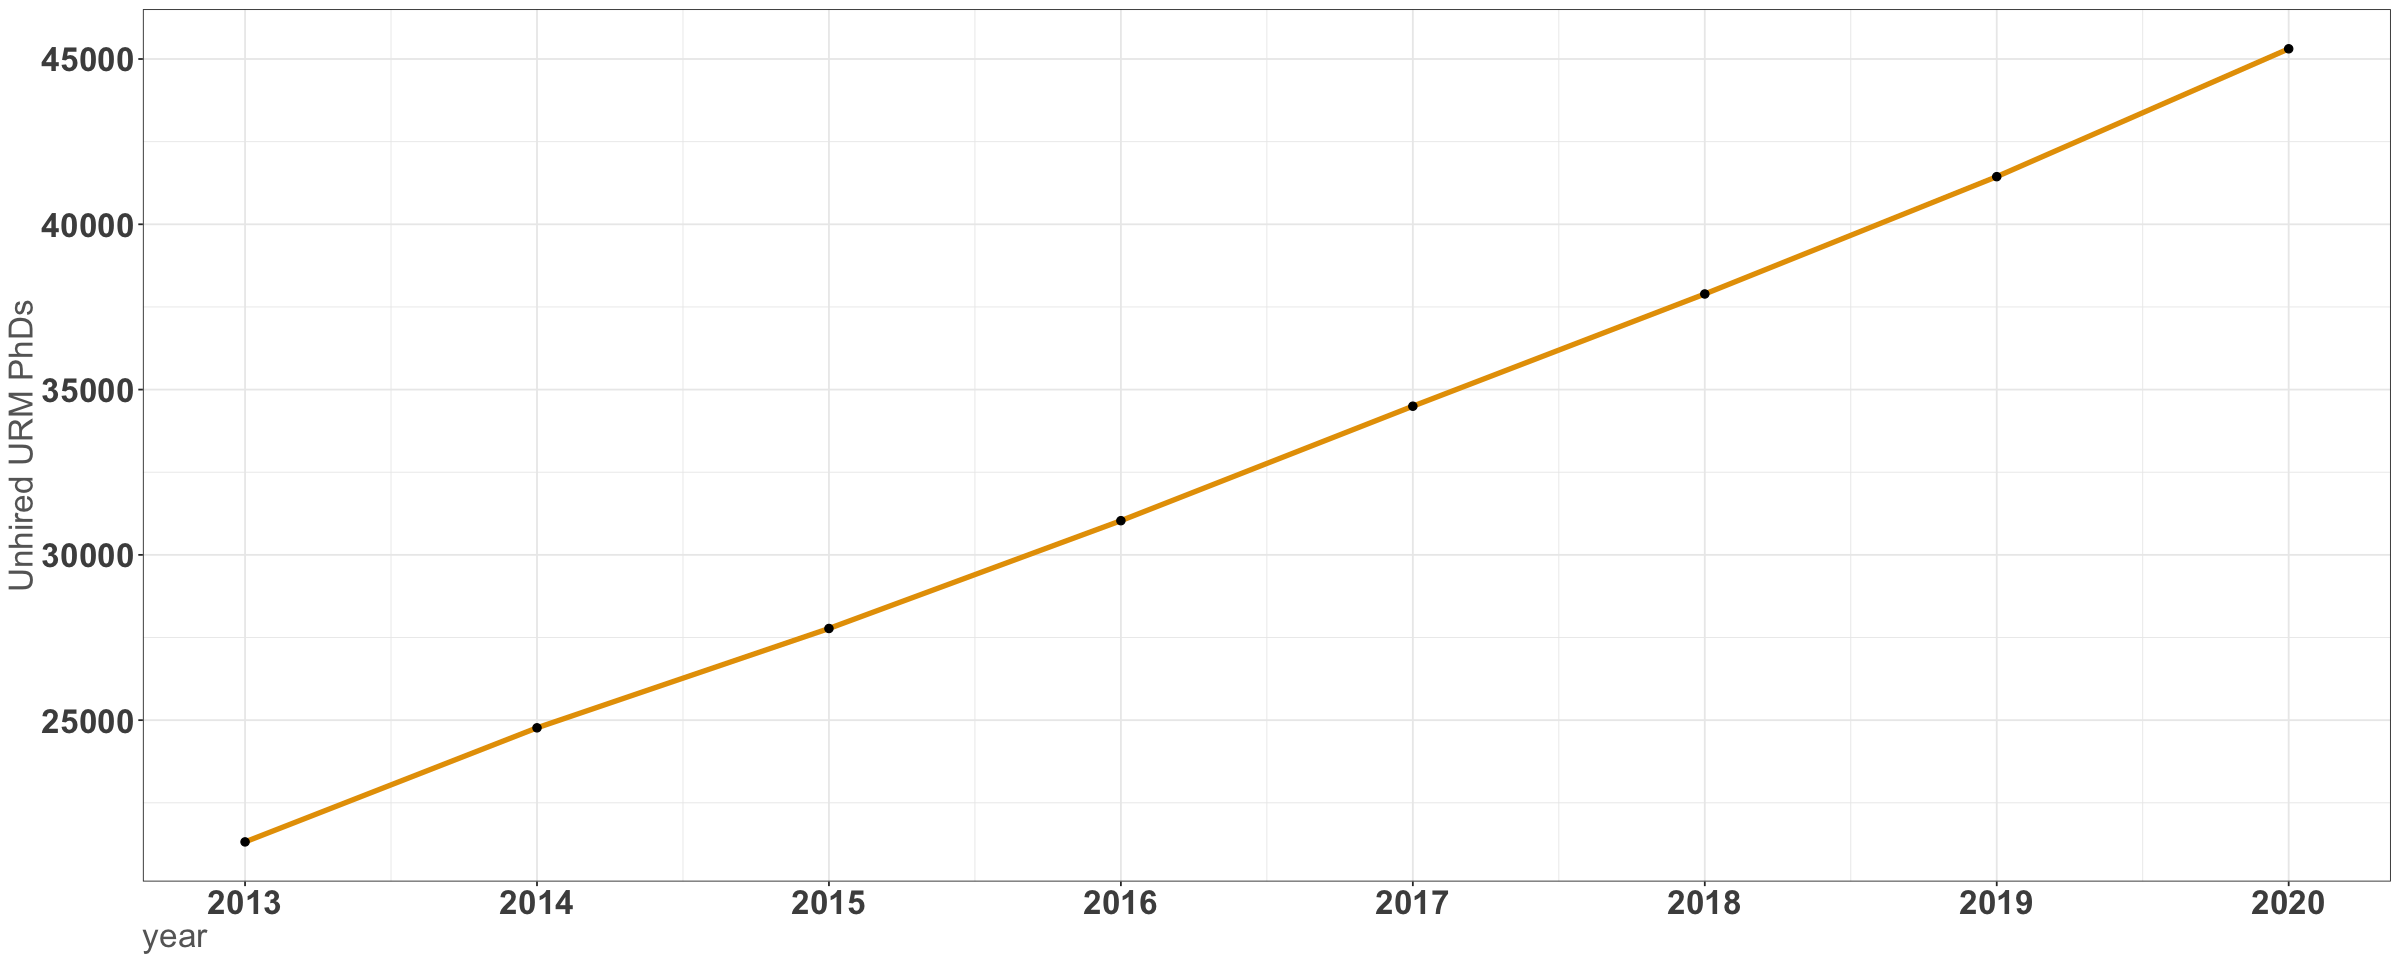

In [328]:
ggplot(merged.df, aes(year, cumulative_unhired_prev_year)) +
    geom_line(size=1.5, color=cbPalette[2]) +
    geom_point(size=2) +
    scale_x_continuous(breaks=seq(2013, 2120, by=1)) +
    theme_bw() +
    theme(text         = element_text(size=20),
          plot.title   = element_text(size=32, face="bold"),
          axis.text.x  = element_text(size=20, face="bold"),
          axis.text.y  = element_text(size=20, face="bold"),
          axis.title.x = element_text(hjust=0, color="#666666"),
          axis.title.y = element_text(color="#666666")) +
    ylab("Unhired URM PhDs")

# Plot Institutions within their Category

* ~TODO: re-generate CSVs to include totals and percentages of tenured and un-tenured URM faculty, for all categories, in summaries and in models~
* ~TODO: Generate chart style ( can do that with one of the existing groups)~

## Load Data
### Load Institutional Categories

In [329]:
#within ivyplus models
ivyplus.models.df <- read.csv(paste(data.path, nces.path, generation.date, "_ivy_plus_regression_table.csv", sep=""),na.strings = "")

#ivyplus vs non ivyplus summaries
ivyplus.summary.df <- read.csv(paste(data.path, nces.path, generation.date, "_ivy_plus_summary_table.csv", sep=""),na.strings = "")

## US News used to get liberal arts colleges
#within usnews models
usnews.models.df <- read.csv(paste(data.path, nces.path, generation.date, "_usnews_regression_table.csv", sep=""),na.strings = "")

#usnews summaries
usnews.summary.df <- read.csv(paste(data.path, nces.path, generation.date, "_usnews_summary_table.csv", sep=""),na.strings = "")


In [330]:
#unique(ivyplus.models.df$dv)

### Load Institutional Statistical Models

In [331]:
institution.models.df <- read.csv(paste(data.path, nces.path, generation.date, "_institution_regression_tables.csv", sep=""),na.strings = "")
colnames(institution.models.df)

[1] "subgroup"        "subgroup_value"  "min_year"        "max_year"       
 [5] "dv"              "formula"         "Intercept"       "year_estimate"  
 [9] "year_pvalue"     "year_stderr"     "usnews_category" "ivy_plus"       
[13] "hsi_hbcu_tribal"

## Comparative plot of institutions
### IvyPlus

In [332]:
#subset(ivyplus.models.df,(dv=="tenured_un_tenured_black_latino_american_indian_alaska_native_hawaiian_pacific_multiracial_total_pct"))

In [453]:
## institution.projections: return a dataframe of models and projections
## for three points for a given institution:
## first point: estimated intercept for the first observed year
## second point: estimated value for the final observed year
## third point: projected value for projection.end.year (defined above)
institution.projections <- function(institution.df, max.observed.year){

    institution.min.year <- as.numeric(substr(institution.df$min_year, 1,4))
    institution.max.year <- as.numeric(substr(institution.df$max_year, 1,4))

    df <- data.frame(
                    name = institution.df$subgroup_value,
                    year = c(institution.min.year, max.observed.year, projection.end.year),
                    estimate = c(
                                institution.df$Intercept*100,
                                institution.df$Intercept*100 + institution.df$year_estimate* (institution.max.year - institution.min.year)*100,
                                institution.df$Intercept*100 + institution.df$year_estimate* (projection.end.year - institution.min.year)*100
                    ))
    df$estimate.upper <- df$estimate + 1.96 * institution.df$year_stderr * 100
    df$estimate.lower <- df$estimate - 1.96 * institution.df$year_stderr * 100
    #print(institution.df$year_stderr)
    return(df)
}

In [473]:
institution.group.chart <- function(subset.institution.models.df,
                                    subgroup.models.df,
                                    subgroup_name,
                                    subgroup_val,
                                    focus.institution,
                                    dv.var = "tenured_un_tenured_black_latino_american_indian_alaska_native_hawaiian_pacific_multiracial_pct",
                                    gdv.var = "tenured_un_tenured_black_latino_american_indian_alaska_native_hawaiian_pacific_multiracial_total_pct"){

    #dv.var = "tenured_un_tenured_black_latino_american_indian_alaska_native_hawaiian_pacific_multiracial_pct"
    #gdv.var = "tenured_un_tenured_black_latino_american_indian_alaska_native_hawaiian_pacific_multiracial_total_pct"
    #subgroup_name = "All Ivy+"
    #focus.institution <- "Cornell University"

    #subset.institution.models.df <- subset(institution.models.df, ivy_plus=="True" & dv==dv.var)

    subset.dv.df <- subset(subgroup.models.df, (dv==gdv.var & subgroup_value==subgroup_val))
    subset.dv.df$subgroup_value = as.character(subset.dv.df$subgroup_value)

    max.observed.year <- max(subset.dv.df$max_year)

    ## Generate projections for every institution in the list
    ## and create a dataframe with those projections
    institution.list = list()

    for(i in seq(1,nrow(subset.institution.models.df))){
        i.df <- institution.projections(subset.institution.models.df[i,], max.observed.year)
        institution.list[[i]] = i.df
    }

    institution.projections.df <- do.call(rbind, institution.list)

    ## generate projections for the group of institutions
    group.projections.df <- institution.projections(subset.dv.df, max.observed.year)
    group.projections.df$name <- subgroup_name
#    group.projections.df

    ## generate projections for demographic parity target
    parity.projections.df <- data.frame(
        year = c(2013, 2020, projection.end.year),
        estimate = c(urm.prop.adjusted*100 - 7*0.2,
                     urm.prop.adjusted*100,
                     urm.prop.adjusted*100 + 0.2*(projection.end.year-2020)),
        name="Demographic parity",
        focus.institution = NA
    )
#     parity.projections.df
#     institution.projections.df
    
    institution.projections.df$focus.institution <- institution.projections.df$name==focus.institution
    group.projections.df$focus.institution <- NA    

    ## GENERATE PLOT
    institution.projection.chart <- 
        ggplot(institution.projections.df, aes(year, estimate, group=name, color=focus.institution)) +

        #     # subgroup lines
            geom_line(data=group.projections.df, aes(year, estimate), color=cbPalette[4], alpha=0.2, size=25) +

        #     ## institution lines
            geom_line(data=subset(institution.projections.df, year<=2020), size=1.5) +
            geom_line(data=subset(institution.projections.df, year>=2020), size=1.5, linetype="dashed") +

            ## Focus institution on top
             geom_line(data=subset(institution.projections.df, year<=2020 & focus.institution==TRUE), size=1.5) +
             geom_line(data=subset(institution.projections.df, year>=2020 & focus.institution==TRUE), size=1.5, linetype="dashed") +

            ## demograhic parity
            geom_line(data=parity.projections.df, size=2, color="black") +

            theme_bw() +
            scale_color_manual(values=c("#cccccc", "#E69F00"), name=focus.institution) +
            scale_x_discrete(limits=seq(2010,projection.end.year, 10)) +
            coord_cartesian(ylim = c(0, max(parity.projections.df$estimate)), xlim = c(2010,2060)) +
            theme(text         = element_text(size=20),
                  plot.title   = element_text(size=32, face="bold"),
                  axis.text.x  = element_text(size=20, face="bold"),
                  axis.text.y  = element_text(size=20, face="bold"),
                  axis.title.x = element_text(hjust=0, color="#666666"),
                  axis.title.y = element_text(color="#666666")) +
            ylab("Percent URM Faculty") +
            ggtitle(paste("Projections for ", subgroup_name, sep=""))
            #ggtitle(paste("No ",subgroup_name," university will reach demographic parity among faculty by 2060", "\nwithout substantial change in hiring and retention", sep=""))

    institution.projection.chart + ggsave(paste("../figures/",tolower(gsub(" ","_",subgroup_name)),"_projection.svg",sep=""), width=18, height=8, device="svg")
    return(institution.projection.chart)
}

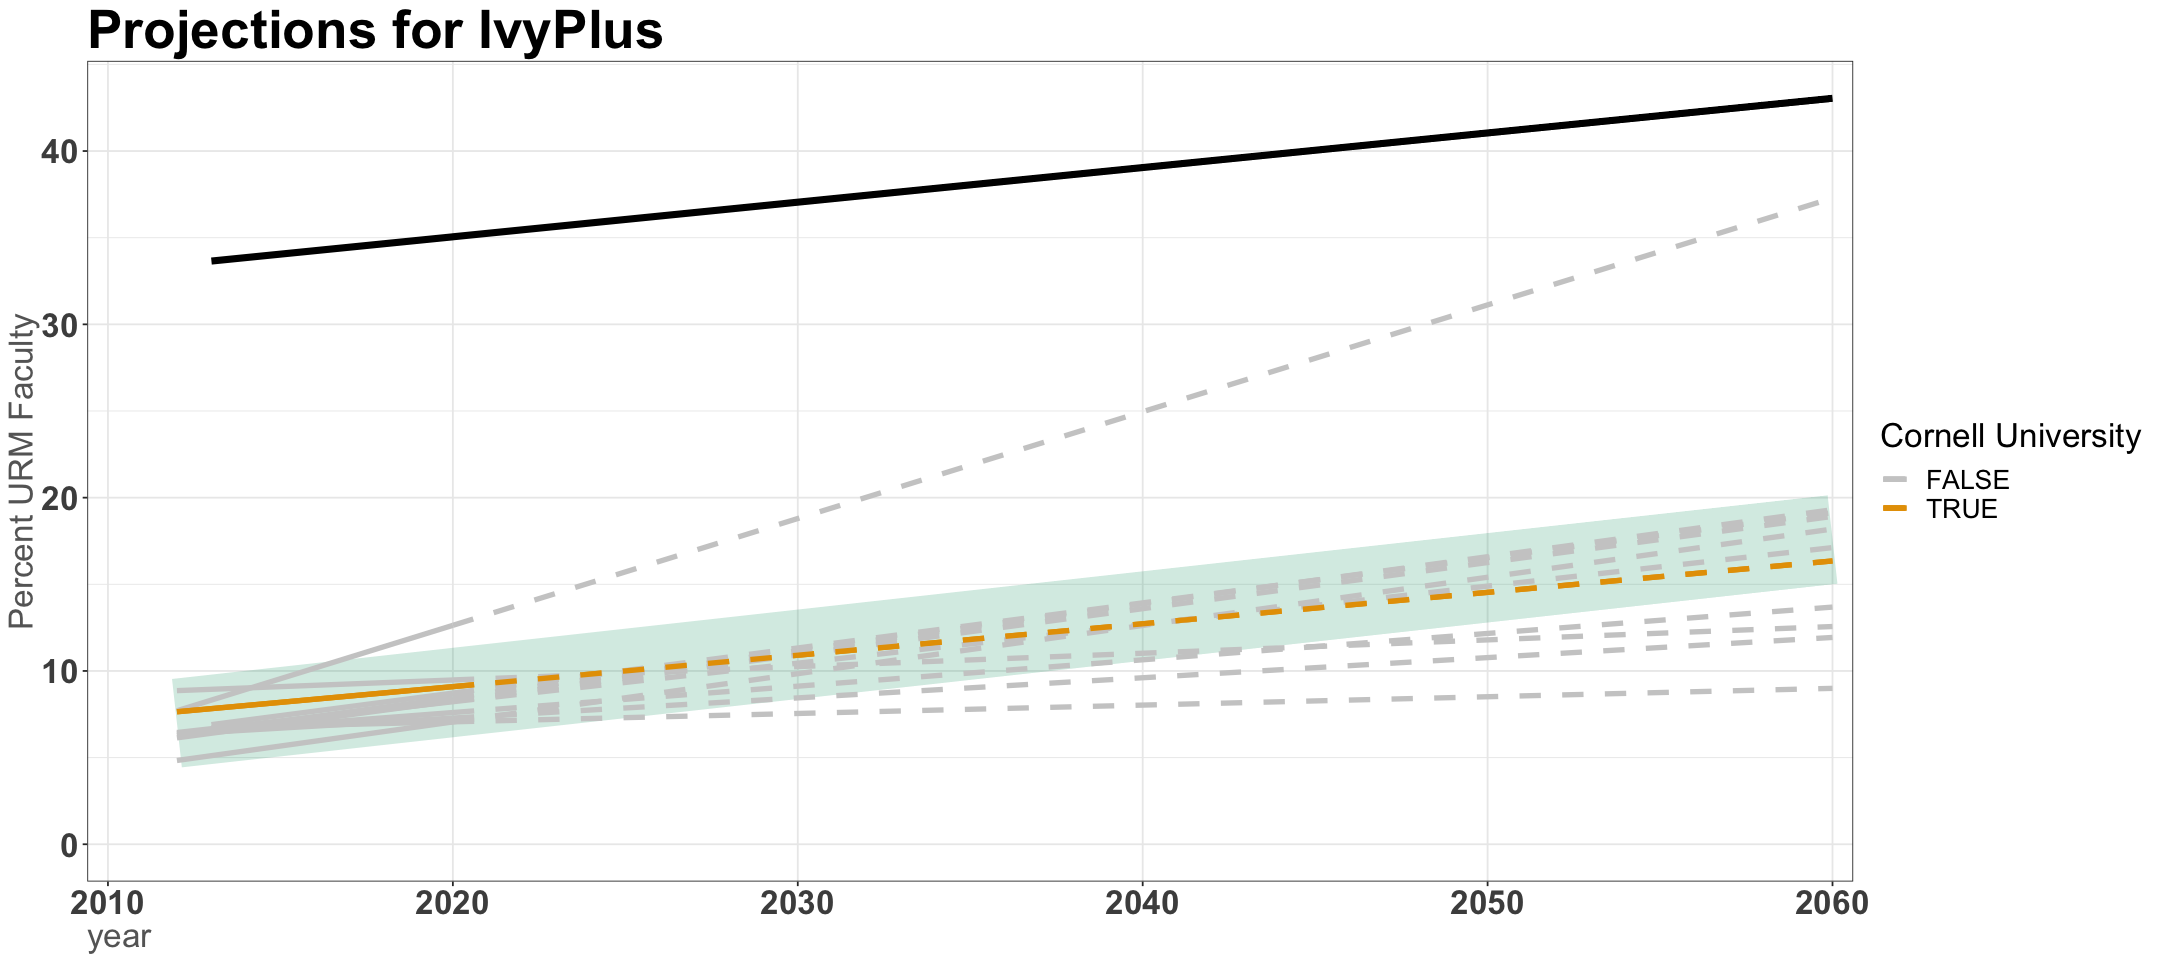

In [474]:
options(repr.plot.width=18, repr.plot.height=8)

dv.var = "tenured_un_tenured_black_latino_american_indian_alaska_native_hawaiian_pacific_multiracial_pct"

institution.group.chart(subset(institution.models.df, ivy_plus=="True" & dv==dv.var),
                        ivyplus.models.df,
                        "IvyPlus",
                        "True",
                        "Cornell University")


#### National Universities, according to US News

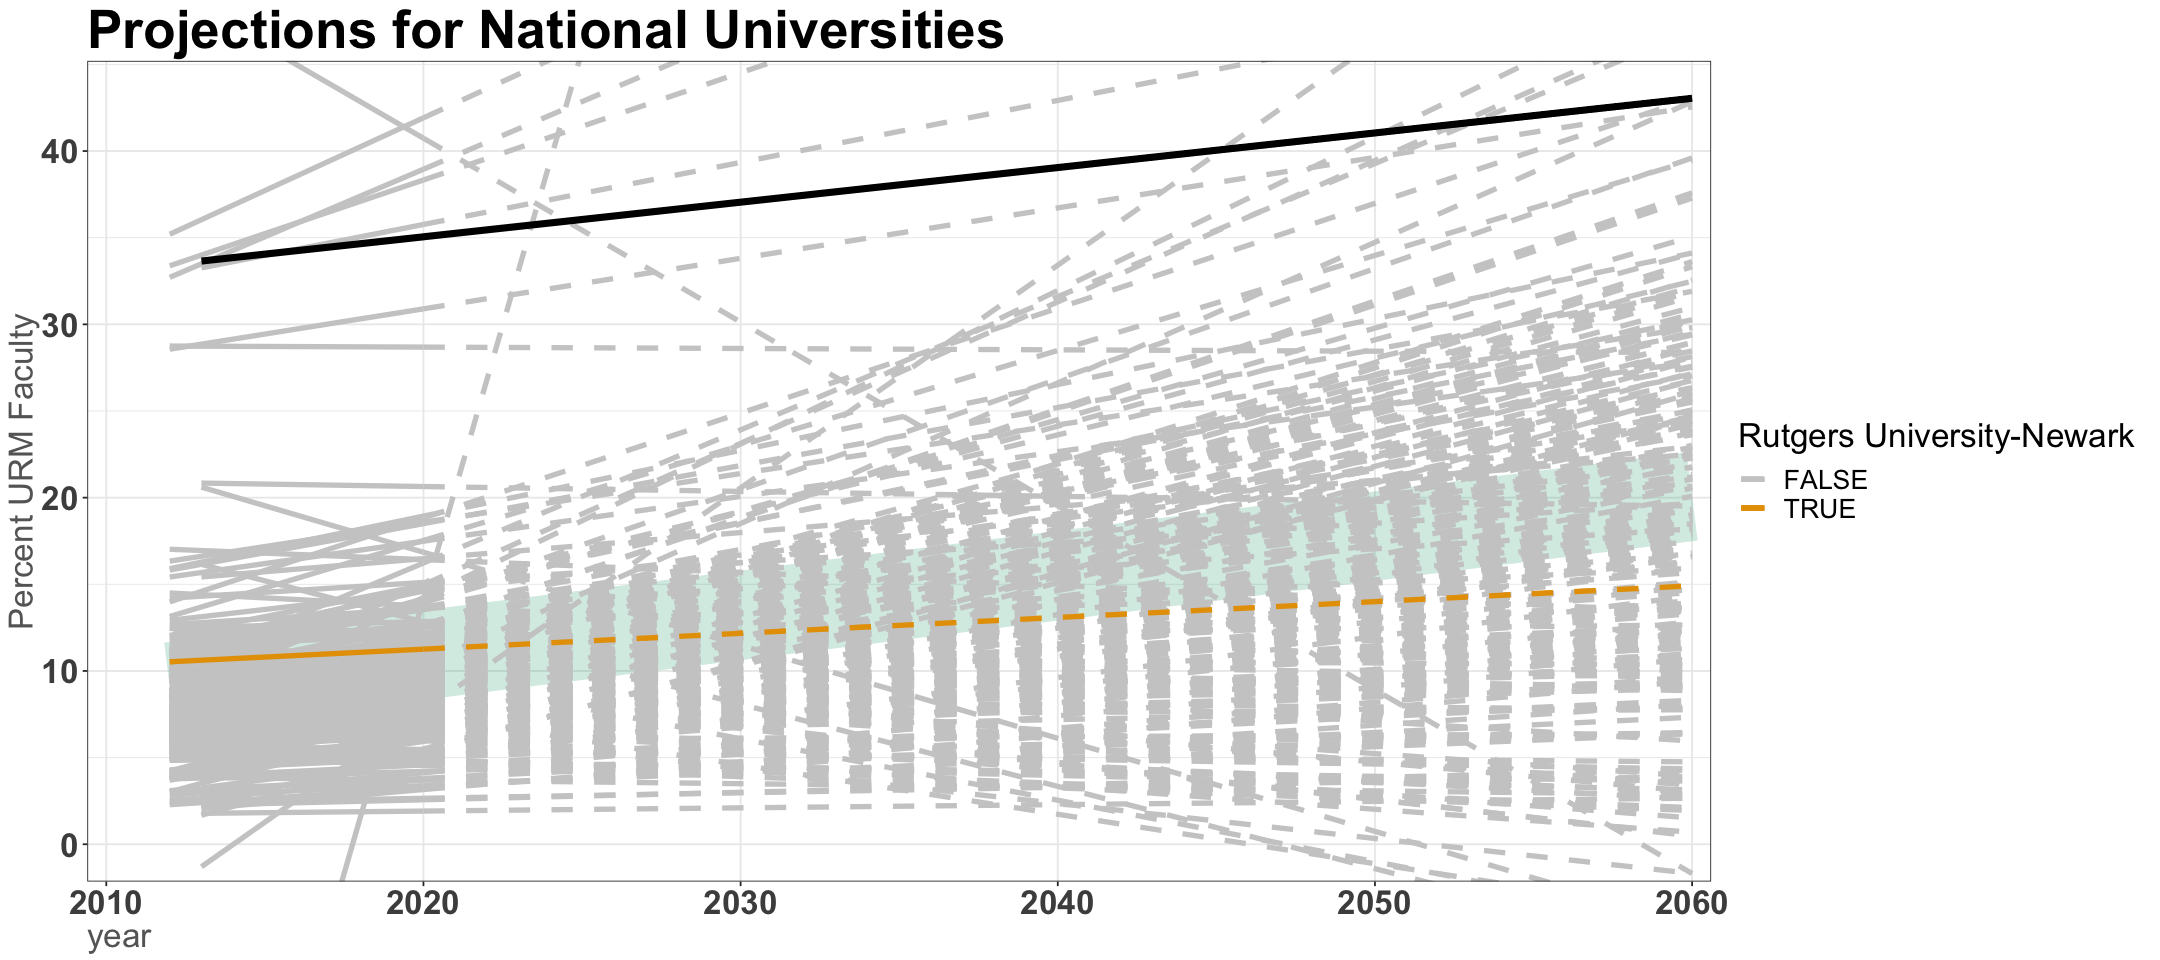

In [475]:
dv.var = "tenured_un_tenured_black_latino_american_indian_alaska_native_hawaiian_pacific_multiracial_pct"
institution.group.chart(subset(institution.models.df, usnews_category=="National Universities" & dv==dv.var),
                        usnews.models.df,
                        "National Universities",
                        "National Universities",
                        "Rutgers University-Newark")


#### National Liberal Arts Colleges, according to US News

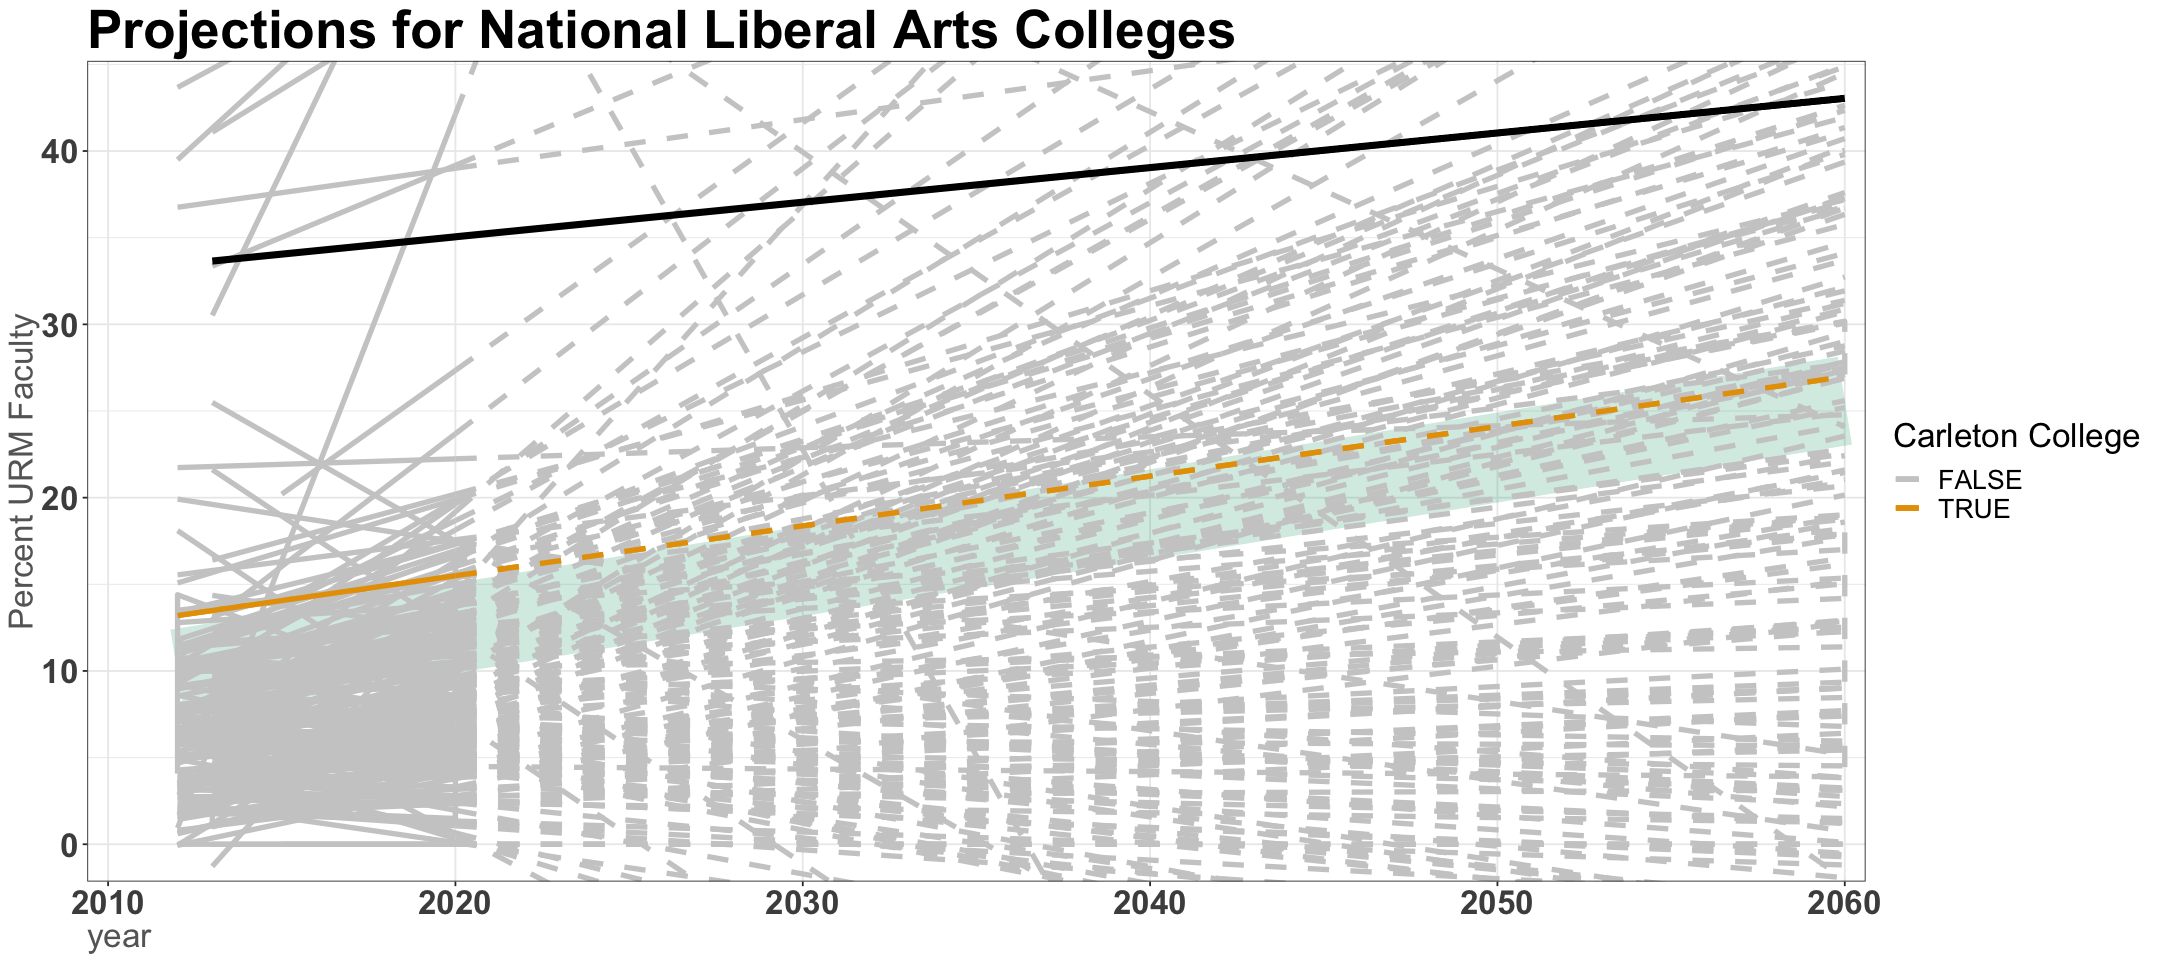

In [476]:
#options(repr.matrix.max.rows=20)

dv.var = "tenured_un_tenured_black_latino_american_indian_alaska_native_hawaiian_pacific_multiracial_pct"
institution.group.chart(subset(institution.models.df, usnews_category=="National Liberal Arts Colleges" & dv==dv.var),
                        usnews.models.df,
                        "National Liberal Arts Colleges",
                        "National Liberal Arts Colleges",
                        "Carleton College")


In [406]:
# dv.var = "tenured_un_tenured_black_latino_american_indian_alaska_native_hawaiian_pacific_multiracial_pct"

# head(subset(institution.models.df, usnews_category=="National Universities" & dv==dv.var & year_estimate ==
#        median(subset(institution.models.df, usnews_category=="National Universities" & dv==dv.var)$year_estimate)))
# #head(institution.models.df)

In [405]:
# ggplot(subset(institution.models.df, usnews_category=="National Universities" & dv==dv.var), aes(Intercept, year_estimate, color=factor(hsi_hbcu_tribal))) +
#     geom_point()

In [458]:
median(subset(institution.models.df, usnews_category=="National Liberal Arts Colleges" & dv==dv.var)$year_estimate)

[1] 0.002849913

In [463]:
# options(repr.matrix.max.rows=200)

# tmp.df <- subset(institution.models.df, usnews_category=="National Liberal Arts Colleges" & dv==dv.var)[c("subgroup_value", "Intercept", "year_estimate")]
# tmp.df[order(tmp.df$year_estimate),]
# nrow(tmp.df)

In [467]:
subset(usnews.models.df, subgroup_value=="National Universities" & dv=="tenured_un_tenured_black_latino_american_indian_alaska_native_hawaiian_pacific_multiracial_total_pct")

,subgroup,subgroup_value,min_year,max_year,dv,formula,Intercept,year_estimate,year_pvalue,year_stderr
274,usnews_category,National Universities,2012,2020,tenured_un_tenured_black_latino_american_indian_alaska_native_hawaiian_pacific_multiracial_total_pct,tenured_un_tenured_black_latino_american_indian_alaska_native_hawaiian_pacific_multiracial_total_pct ~ year_num,0.09088939,0.002287911,2.51539e-07,0.0001186593


In [280]:
# subset(usnews.models.df$subgroup_value)

[1] Regional Universities—Midwest                            
 [2] Regional Colleges—Northeast                              
 [3] National Liberal Arts Colleges                           
 [4] National Universities                                    
 [5] Special Focus Four-Year: Engineering Schools             
 [6] Regional Colleges—South                                  
 [7] Regional Universities—West                               
 [8] Regional Colleges—West                                   
 [9] Special Focus Four-Year: Medical Schools & Centers       
[10] Special Focus Four-Year: Arts, Music & * Schools         
[11] Regional Universities—South                              
[12] Regional Universities—Northeast                          
[13] Special Focus Four-Year: Other Health Professions Schools
[14] Special Focus Four-Year: Other Technology-Related Schools
[15] Special Focus Four-Year: Other Special Focus Institutions
[16] Special Focus Four-Year: Law Schools                     
[17] Regional Colleges—Midwest                                
[18] Special Focus Four-Year: Faith-Related Institutions      
[19] Special Focus Four-Year: Business & Management Schools   
19 Levels: National Liberal Arts Colleges ... Special Focus Four-Year: Other Technology-Related Schools

# Output variables to file accessible by the paper

In [1]:
example.variable <- "Hello, I am example variable"

In [ ]:
save(list=ls(), file="paper-data.RData", version = 2) # overleaf uses R 3.4 which requires version 2 of Rdata I believe